In [217]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D



In [218]:
# Use pandas to read the combined returns data from CSV

combined_returns_df = pd.read_csv('COMBINED_RETURNS.csv')

# Convert DataFrame to numpy array
combined_returns = combined_returns_df.values

# Calculate the mean returns and the covariance matrix for optimization
mean_returns = np.mean(combined_returns, axis=0)
cov_matrix = np.cov(combined_returns, rowvar=False)

print(mean_returns)

print("Covariance Matrix:")
print(pd.DataFrame(cov_matrix, columns=combined_returns_df.columns, index=combined_returns_df.columns))






[0.00378477 0.00488902 0.00709633 0.00842891]
Covariance Matrix:
              ASX   Zone_1A    Zone_6    Zone_7
ASX      0.001585 -0.000139 -0.000081 -0.000161
Zone_1A -0.000139  0.001817  0.000356  0.000574
Zone_6  -0.000081  0.000356  0.004357  0.000457
Zone_7  -0.000161  0.000574  0.000457  0.001749


In [219]:
def sharpe_ratio(weights, returns, risk_free_rate, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    return -sharpe_ratio  # Minimize the negative Sharpe ratio

def sharpe_ratio_gradient(weights, returns, risk_free_rate, cov_matrix):
    portfolio_return = np.dot(weights, returns)
    portfolio_volatility = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    sharpe_ratio = (portfolio_return - risk_free_rate) / portfolio_volatility
    
    gradient = (returns - risk_free_rate - sharpe_ratio * np.dot(cov_matrix, weights) / portfolio_volatility) / portfolio_volatility
    return -gradient  # Minimize the negative Sharpe ratio



def sgd_optimization(returns, cov_matrix, risk_free_rate, num_iterations, initial_weights, step_size, decay_rate): 
    weights = initial_weights
    sharpe_values = []  # List to store Sharpe ratios
    weights_history = []  # List to store weights at each iteration

    for i in range(num_iterations):
        # Calculate the gradient of the Sharpe ratio with respect to the weights
        gradient = sharpe_ratio_gradient(weights, returns, risk_free_rate, cov_matrix)
        
        # Update the weights using the gradient and step size
        weights -= step_size * gradient
        
        # Project the weights onto the feasible set
        weights /= np.sum(weights)  # Normalize weights to sum to 1
        weights = np.maximum(0, weights)  # Ensure non-negativity
        
        # Decay the learning rate
        step_size *= decay_rate
        
        # Calculate and store the current Sharpe ratio
        current_sharpe = -sharpe_ratio(weights, returns, risk_free_rate, cov_matrix)  # Negative because we minimized the negative in optimization
        sharpe_values.append(current_sharpe)
        weights_history.append(weights.copy())  # Store a copy of the current weights
    
    return weights, sharpe_values, weights_history


# Parameters
num_assets = 4
num_iterations = 20
initial_weights = np.array([0.25, 0.25, 0.25, 0.25])
step_size = 0.1
decay_rate = 0.98
risk_free_rate = 0.0204


# returns and covariance matrix
returns = np.array(mean_returns)



# Run the optimization
optimal_weights, sharpe_values, weights_history = sgd_optimization(returns, cov_matrix, risk_free_rate, num_iterations, initial_weights, step_size, decay_rate)

print("Optimal portfolio weights:", optimal_weights)
import pandas as pd

# Create a DataFrame to display the optimal weights in a table
assets = ['ASX', 'Trading Zone 1A', 'Trading Zone 6', 'Trading Zone 7']
optimal_weights_df = pd.DataFrame(np.round(optimal_weights, 4), index=assets, columns=['Optimal Allocation'])
optimal_weights_df.replace(0, '0', inplace=True)  # Simplify 0 to '0'

# Display the table
print("Optimal Portfolio Weights Table:")
print(optimal_weights_df)


Optimal portfolio weights: [0.         0.         0.84987688 0.18706853]
Optimal Portfolio Weights Table:
                Optimal Allocation
ASX                              0
Trading Zone 1A                  0
Trading Zone 6              0.8499
Trading Zone 7              0.1871


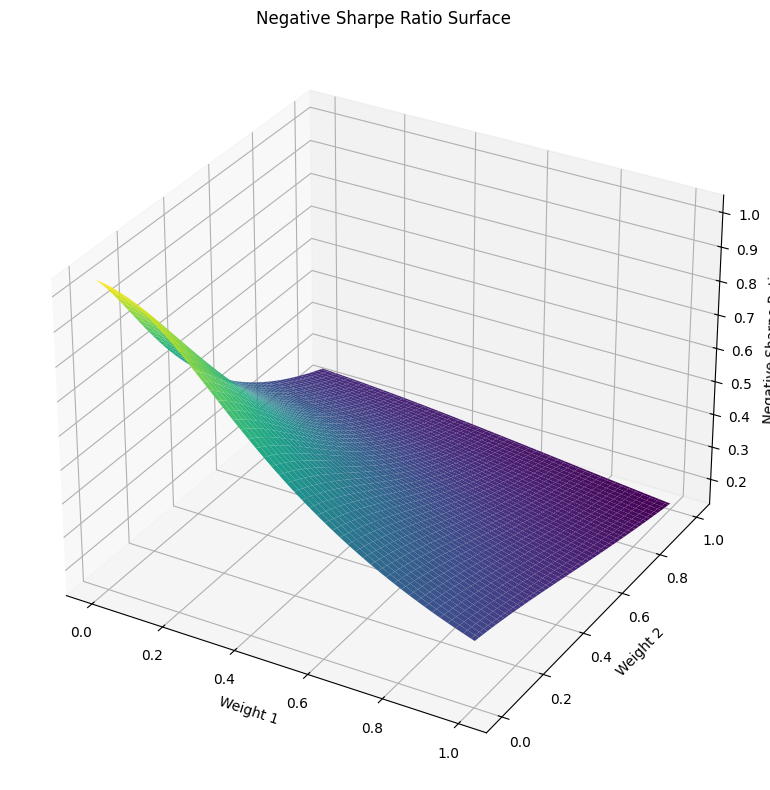

In [220]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Create a grid of weights for two assets
weight1_range = np.linspace(0, 1, 100)
weight2_range = np.linspace(0, 1, 100)
weight1_grid, weight2_grid = np.meshgrid(weight1_range, weight2_range)

# Calculate the negative Sharpe ratio for each combination of weights
sharpe_surface = np.zeros_like(weight1_grid)
for i in range(weight1_grid.shape[0]):
    for j in range(weight1_grid.shape[1]):
        weights = np.array([weight1_grid[i, j], weight2_grid[i, j], 0.2, 0.2])
        sharpe_surface[i, j] = sharpe_ratio(weights, returns, risk_free_rate, cov_matrix)

# Plot the negative Sharpe ratio surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(weight1_grid, weight2_grid, sharpe_surface, cmap='viridis')
ax.set_xlabel('Weight 1')
ax.set_ylabel('Weight 2')
ax.set_zlabel('Negative Sharpe Ratio')
ax.set_title('Negative Sharpe Ratio Surface')
plt.tight_layout()
plt.show()

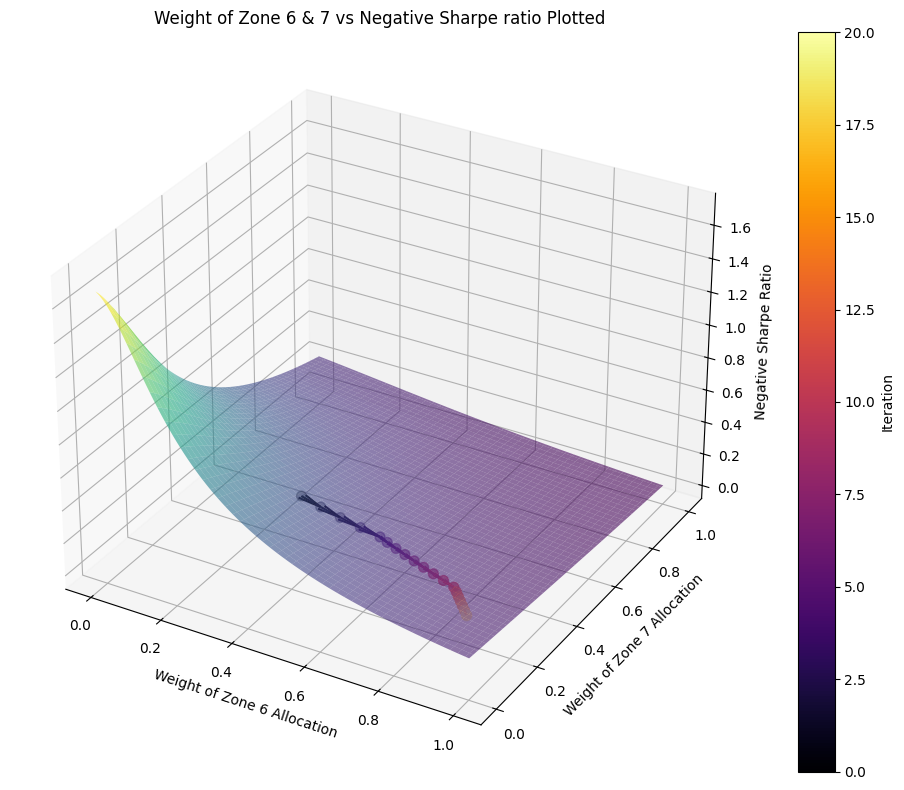

In [221]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import viridis, inferno_r, magma
from matplotlib.colors import Normalize
from matplotlib.colors import LinearSegmentedColormap

# Create a custom color map from red to white
red_white_cmap = LinearSegmentedColormap.from_list("red_white", ["red", "white"])


# Create a grid of weights for the last two assets
weight3_range = np.linspace(0, 1, 100)
weight4_range = np.linspace(0, 1, 100)
weight3_grid, weight4_grid = np.meshgrid(weight3_range, weight4_range)

# Calculate the negative Sharpe ratio for each combination of weights
sharpe_surface = np.zeros_like(weight3_grid)
for i in range(weight3_grid.shape[0]):
    for j in range(weight4_grid.shape[1]):
        weights = np.array([0.2, 0.2, weight3_grid[i, j], weight4_grid[i, j]])
        sharpe_surface[i, j] = sharpe_ratio(weights, returns, risk_free_rate, cov_matrix)

# Run the optimization and store the weights at each iteration
weights_history = []
weights = initial_weights
for i in range(num_iterations):
    gradient = sharpe_ratio_gradient(weights, returns, risk_free_rate, cov_matrix)
    weights -= step_size * gradient
    weights /= np.sum(weights)
    weights = np.maximum(0, weights)
    weights_history.append(weights)

# Plot the negative Sharpe ratio surface
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(weight3_grid, weight4_grid, sharpe_surface, cmap='viridis', alpha=0.6)

# Plot the SGD path
weights_history = np.array(weights_history)
sharpe_values = np.array([sharpe_ratio(w, returns, risk_free_rate, cov_matrix) for w in weights_history])
colors = magma(np.linspace(0, 1, len(weights_history)))
sc = ax.scatter(weights_history[:, 2], weights_history[:, 3], sharpe_values, c=colors, s=50)

# Draw arrows connecting the points with color changing over time
for i in range(len(weights_history) - 1):
    ax.quiver(weights_history[i, 2], weights_history[i, 3], sharpe_values[i],
              weights_history[i+1, 2] - weights_history[i, 2], weights_history[i+1, 3] - weights_history[i, 3],
              sharpe_values[i+1] - sharpe_values[i],
              color=colors[i], arrow_length_ratio=1)


# Add a color bar
norm = Normalize(vmin=0, vmax=len(weights_history))
cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap='inferno'), ax=ax, orientation='vertical', pad=0.05)
cbar.set_label('Iteration')

ax.set_xlabel('Weight of Zone 6 Allocation')
ax.set_ylabel('Weight of Zone 7 Allocation')
ax.set_zlabel('Negative Sharpe Ratio')
ax.set_title('Weight of Zone 6 & 7 vs Negative Sharpe ratio Plotted')
plt.tight_layout()
plt.show()